In [43]:
import ast
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
from os import getenv
from openai import OpenAI
import pathlib
import textwrap
import google.generativeai as genai
import time

load_dotenv("../.env",override=True)
GOOGLE_API_KEY = getenv("GEMINI_API_KEY")
OPENAI_API_KEY = getenv("OPENAI_API_KEY")


sample_df = pd.read_csv("./output/sample_df_industry_level_embeddings.csv")
sample_df['openai_embedding_entire'] = sample_df['openai_embedding_entire'].apply(ast.literal_eval)
sample_df = sample_df.dropna(subset=['parsed_description'])
sample_df.head()

Unnamed: 0                       organization name num employees  \
0       22341                                  Fytted          1-10   
1       18944       Semilla Co. (Flou / Seed Academy)          1-10   
2       19082  ChatGPT Nederlands - GPTNederlands.com          1-10   
3       17578                               Pelles.ai          1-10   
4       22004                              SimLoop AI          1-10   

  founded date                                        description  \
0   2024-03-01                                                  —   
1   2023-02-01  Semilla Co. ("Seed") is building the future of...   
2   2023-02-03  GPTNederlands.com is dé toonaangevende bestemm...   
3   2023-01-01  Pelles.ai transforms the way MEP (mechanical, ...   
4   2024-01-02  SimLoop allows companies run experiments with ...   

                                          industries  \
0                                                  —   
1  Consumer Software, Content Creators, EdTech, L...   
2                                                  —   
3                       Construction, SaaS, Software   
4  Analytics, Artificial Intelligence (AI), Gener...   

                     headquarters location  \
0        Venice, California, United States   
1  Fort Lauderdale, Florida, United States   
2                                        —   
3        New York, New York, United States   
4                                        —   

                                       description.1    cb rank postal code  \
0                      SaaS, Mobile App, AI, Fashion          —       90292   
1  Building the future of the music and entertain...     43,978       33316   
2  GPTNederlands.com is dé toonaangevende bestemm...  1,885,621           —   
3                           Auto-Generate MEP Design     62,705           —   
4   User testing platform powered by simulated users    360,457           —   

   ...                                    description_all  \
0  ...                    — SaaS, Mobile App, AI, Fashion   
1  ...  Semilla Co. ("Seed") is building the future of...   
2  ...  GPTNederlands.com is dé toonaangevende bestemm...   
3  ...  Pelles.ai transforms the way MEP (mechanical, ...   
4  ...  SimLoop allows companies run experiments with ...   

                                   industries_parsed  \
0                                                 []   
1  ['Consumer Software', 'Content Creators', 'EdT...   
2                                                 []   
3               ['Construction', 'SaaS', 'Software']   
4                     ['Analytics', 'Generative AI']   

                               generated_description  \
0  Fytted is a SaaS and mobile app that leverages...   
1  Semilla Co., through its two products - Seed A...   
2  ChatGPT Nederlands - GPTNederlands.com is a le...   
3  Pelles.ai is an innovative platform that utili...   
4  SimLoop AI is an innovative platform that enab...   

                                    openai_embedding  \
0  [-0.026910386979579926, 0.00429302453994751, -...   
1  [-0.024784477427601814, -0.007316365372389555,...   
2  [-0.04201542213559151, -0.02567780390381813, -...   
3  [-0.026539845392107964, -0.014325139112770557,...   
4  [-0.04071200266480446, -0.009665796533226967, ...   

                                  Company  \
0                                  Fytted   
1       Semilla Co. (Flou / Seed Academy)   
2  ChatGPT Nederlands - GPTNederlands.com   
3                               Pelles.ai   
4                              SimLoop AI   

                                  parsed_description  \
0  \nTasks/Jobs: Fashion recommendations, Virtual...   
1  \nTasks/Jobs: Music Business Management, Marke...   
2  \nTasks/Jobs: Language translation, Content ge...   
3  \nTasks/Jobs: MEP plan generation, Clash detec...   
4  \nTasks/Jobs: Website testing, User interactio...   

                                          Tasks/Jobs              Industry  \
0  Fashi

In [12]:
# genai.configure(api_key=GOOGLE_API_KEY)
# class gemini():
#     def __init__(self):
#         self.model = genai.GenerativeModel('gemini-1.5-flash')
#     def ask(self,prompt):
#         response = self.model.generate_content(prompt)
#         print(response)
#         if response.candidates[0].finish_reason == 3: return "N/A"
#         response = response.candidates[0].content.parts[0].text
#         return response

# x = gemini()
# x.ask("hi")


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'sample_df' and its 'openai_embedding_entire' column exist and contain appropriate data
embeddings = np.array(sample_df['openai_embedding_entire'].tolist())

similarity_matrix = cosine_similarity(embeddings)
distance_matrix = 1 - similarity_matrix

# Define the number of neighbors
n_neighbors = 5

# Create a KNN model for connectivity based on cosine distance
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
knn.fit(embeddings)
connectivity_matrix = knn.kneighbors_graph(embeddings, mode='connectivity')

# Use Spectral Clustering with the connectivity matrix defined by KNN
clustering = SpectralClustering(n_clusters=100, affinity='precomputed', assign_labels='kmeans', random_state=42)
cluster_labels = clustering.fit_predict(connectivity_matrix)

# Assign cluster labels back to the original DataFrame
sample_df['cluster_label'] = cluster_labels


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [14]:
for i in range(10):
    num_companies = len(sample_df[sample_df["cluster_label"] == i])
    print(f"Cluster {i}, Number of companies: {num_companies}")

Cluster 0, Number of companies: 8
Cluster 1, Number of companies: 6
Cluster 2, Number of companies: 7
Cluster 3, Number of companies: 7
Cluster 4, Number of companies: 4
Cluster 5, Number of companies: 6
Cluster 6, Number of companies: 8
Cluster 7, Number of companies: 9
Cluster 8, Number of companies: 5
Cluster 9, Number of companies: 8


In [15]:
for i in range(0,10):
    print(f"Processing {i}:\n************************\n")
    vals = sample_df[sample_df["cluster_label"]==i][["organization name","generated_description","parsed_description"]]
    for index, row in vals.iterrows():
        print(f"Organization Name: {row['organization name']}")
        print(f"Generated Description: {row['generated_description']}")
        print(f"Generated Description: {row['parsed_description']}\n")
    print(f"************************\n\n")

Processing 0:
************************

Organization Name: fyby.io
Generated Description: Fyby.io is an AI-powered marketplace that assists businesses in discovering, purchasing, and managing software, tech services, and bundled solutions. It streamlines the procurement process by providing a data-driven platform for SaaS products and tech-related service solutions.
Generated Description: 
Tasks/Jobs: Software discovery, Software procurement, Software management, Service discovery
Industry: SaaS Marketplace
People Using Tool: Businesses, IT managers
 


Organization Name: beeta.one
Generated Description: Beeta.one is a digital platform specializing in the development of Internet of Things (IoT) applications through its user-friendly, no-code environment and AI-powered project assistant. Primarily serving SMEs in the DACH and EU markets, it enables businesses to leverage their data, streamline operations, and foster innovation, simplifying the process of digital transformation.
Generate

In [16]:

prompt = f"""
Your role is to generate a label name for the following combined descriptions. Make it simple and understandable. Make it specific to the industry. Do not use vague words like comprehensive. Do not use the word AI-Powered.
EXAMPLE BELOW
_________________
Organization Name: Askflow AI
Generated Description: Product: Product recommendation platform, E-commerce suite solution, Personalized product finders
Target Customers/Industries: E-commerce businesses, Brands and merchants

Organization Name: Neuron Expert
Generated Description: Product: Expert Network Platform, AI Content Builder, Digital Workers, Message Center
Target Customers/Industries: businesses looking to increase sales, social media managers, customer service departments

Organization Name: Consumable AI
Generated Description: Product: SEO performance analysis, Automated SEO content publishing and management
Target Customers/Industries: Online businesses, E-commerce platforms, Digital marketing agencies

Organization Name: WNE3
Generated Description: Product: E-commerce platform, Generative AI, ONDC
Target Customers/Industries: Online shoppers, Retail industry

Organization Name: Anarix
Generated Description: Product: Marketplace Optimization Platform, Advertising Management, Amazon Marketing Cloud (AMC), Review Sentiment Analysis, Listing Optimization, Comprehensive Reporting Capabilities, Customizable Visualization Tools
Target Customers/Industries: Agencies, Brands, Online Sellers, E-commerce Businesses

Organization Name: Plugin Support
Generated Description: Product: Customer Support Services, Plugin Support, Real-time Interactions
Target Customers/Industries: Software companies, Tech startups, E-commerce businesses

Organization Name: InboxIgniter
Generated Description: Product: Email Warmup Tool, Outreach Campaign Management
Target Customers/Industries: Email Marketers, Sales Teams, PR Agencies

Label Name: E-commerce and Sales
_________________
Now, your turn:
Descriptions: $descriptions
Label name:
"""




In [21]:

prompt = f"""
Your role is to choose a label for the following combined descriptions of company's using the list below.
List of options:
_________________________
Fashion and Design
Music and Audio Production Tools
Construction and Workflow Automation
Web Development and AI tools
AI Research and Development
Tech and Blockchain News
Retail Supply Chain Management
Advanced Cybersecurity Solutions
Technology and Business Integration
Educational Technologies and Learning Platforms
Healthcare Data Management Systems
Logistics and Transportation Solutions
Mobile and Software Development Technologies
Creative Business Tools
Restaurant and Hospitality Services
Regulatory Compliance and Risk Management
Gamification in Education
Marketing Data Analytics
AI Systems Development
Customer Service Innovations
E-commerce and Retail Strategies
AI-Driven Business Strategies
Social Media and Marketing Strategies
Customer Data Analysis
Business Support Solutions
Automated Business Systems
Customer Relationship Management
Career Development Tools
Veterinary and Pet Care Technologies
AI for Business Enhancements
Legal and Technological Automation
Data Insights and Analytics
Travel Booking and Planning Systems
AI Educational Resources
Development Tools Automation
Social Media and Digital Insights
Privacy-Focused Cybersecurity
AI Toolset for Developers
Real Estate Investment Analysis
AI in Clinical Assistance
Financial Management Systems
Comprehensive Business Solutions
No-Code AI Platforms
Healthcare Workflow Optimization
Venture Capital and Financing
Sustainability and Non-Profit Solutions
Wellness and Sleep Health
Industrial Sales Automation
Tax and Accounting Automation
Image Enhancement Solutions
Content Marketing Tools
HR and Recruitment Automation
Home and Interior Design
Hospitality Management
Financial Compliance Systems
Mental Health and Therapy
Market and Business Strategy
Personalized Wellness Programs
Learning Management Systems
Technical Writing and Proposals
Biotechnological Research
Project and Team Management
E-commerce Management
Industrial Sourcing Solutions
Decentralized Tech and Identity
Quality Assurance in AI
Creative Content and Media Tools
Real Estate Safety and Trust
Client Management in Legal Services
Animation and Visual Effects Tools
Social and Event Planning Tools
Document Management Automation
Infrastructure Management in DevOps
Design and Marketing Innovations
Solutions for Industrial Automation
Language and Speech Learning
Insurance Management Services
Personal Growth and Development
Sales and Marketing Outreach
High-Performance Computing Solutions
Data Management and Quality Control
___________________________________
Now, your turn:
Descriptions: $descriptions
Label name:

"""

In [22]:
class chatGPT():
    def __init__(self):
        self.client = OpenAI(api_key=OPENAI_API_KEY)
        
    def ask(self, q):
        stream = self.client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": q}],
            stream=True,
            temperature=0
        )
        response = ""
        for chunk in stream:
            if chunk.choices[0].delta.content is not None:
                response += chunk.choices[0].delta.content

        self.response = response
        return response

    def get_embedding(self,text, model="text-embedding-3-large"):
       text = text.replace("\n", " ")
       return self.client.embeddings.create(input = [text], model=model).data[0].embedding

x = chatGPT()

In [23]:



cluster_labels = {}

for index, label in enumerate(sample_df['cluster_label'].unique()):
    print(f"Processing {index}")
    descriptions = list(sample_df[sample_df['cluster_label'] == label]['parsed_description'])
    descriptions = " ".join(descriptions)
    while True:
        try:
            p1 = prompt.replace("$descriptions",descriptions)
            text_label = x.ask(p1)
            cluster_labels[label] = text_label
            print(text_label)
            break
        except Exception as e:
            print(f"Error processing: {e}")
            time.sleep(20)



sample_df['generated_cluster_label'] = sample_df['cluster_label'].map(cluster_labels)





Processing 0
Fashion and Design
Processing 1
Music and Audio Production Tools
Processing 2
AI Toolset for Developers
Processing 3
Construction and Workflow Automation
Processing 4
Web Development and AI tools
Processing 5
AI Research and Development
Processing 6
Tech and Blockchain News
Processing 7
HR and Recruitment Automation
Processing 8
Retail Supply Chain Management
Processing 9
Advanced Cybersecurity Solutions
Processing 10
Mobile and Software Development Technologies
Processing 11
Educational Technologies and Learning Platforms
Processing 12
Healthcare Data Management Systems
Processing 13
Logistics and Transportation Solutions
Processing 14
Mobile and Software Development Technologies
Processing 15
Creative Business Tools
Processing 16
Restaurant and Hospitality Services
Processing 17
Regulatory Compliance and Risk Management
Processing 18
Gamification in Education
Processing 19
Marketing Data Analytics
Processing 20
AI Research and Development
Processing 21
Personalized Welln

In [48]:
# sample_df['generated_cluster_label'] = sample_df['generated_cluster_label'].apply(lambda x: str(x).replace("Label Name: ","").replace("Label name:","").replace("\n","").replace("**","").strip())
# sample_df.generated_cluster_label = sample_df.generated_cluster_label.apply(lambda x: x.replace("AI-Powered ",""))

sample_df.to_csv("./output/sample_df_with_generated_labels2.csv")

In [44]:
# import ast
# sample_df = pd.read_csv("./output/sample_df_with_generated_labels2.csv")
# sample_df['openai_embedding_entire'] = sample_df['openai_embedding_entire'].apply(ast.literal_eval)
# sample_df.head()

Unnamed: 0.1  Unnamed: 0                       organization name  \
0             0       22341                                  Fytted   
1             1       18944       Semilla Co. (Flou / Seed Academy)   
2             2       19082  ChatGPT Nederlands - GPTNederlands.com   
3             3       17578                               Pelles.ai   
4             4       22004                              SimLoop AI   

  num employees founded date  \
0          1-10   2024-03-01   
1          1-10   2023-02-01   
2          1-10   2023-02-03   
3          1-10   2023-01-01   
4          1-10   2024-01-02   

                                         description  \
0                                                  —   
1  Semilla Co. ("Seed") is building the future of...   
2  GPTNederlands.com is dé toonaangevende bestemm...   
3  Pelles.ai transforms the way MEP (mechanical, ...   
4  SimLoop allows companies run experiments with ...   

                                          industries  \
0                                                  —   
1  Consumer Software, Content Creators, EdTech, L...   
2                                                  —   
3                       Construction, SaaS, Software   
4  Analytics, Artificial Intelligence (AI), Gener...   

                     headquarters location  \
0        Venice, California, United States   
1  Fort Lauderdale, Florida, United States   
2                                        —   
3        New York, New York, United States   
4                                        —   

                                       description.1    cb rank  ...  \
0                      SaaS, Mobile App, AI, Fashion          —  ...   
1  Building the future of the music and entertain...     43,978  ...   
2  GPTNederlands.com is dé toonaangevende bestemm...  1,885,621  ...   
3                           Auto-Generate MEP Design     62,705  ...   
4   User testing platform powered by simulated users    360,457  ...   

                               generated_description  \
0  Fytted is a SaaS and mobile app that leverages...   
1  Semilla Co., through its two products - Seed A...   
2  ChatGPT Nederlands - GPTNederlands.com is a le...   
3  Pelles.ai is an innovative platform that utili...   
4  SimLoop AI is an innovative platform that enab...   

                                    openai_embedding  \
0  [-0.026910386979579926, 0.00429302453994751, -...   
1  [-0.024784477427601814, -0.007316365372389555,...   
2  [-0.04201542213559151, -0.02567780390381813, -...   
3  [-0.026539845392107964, -0.014325139112770557,...   
4  [-0.04071200266480446, -0.009665796533226967, ...   

                                  Company  \
0                                  Fytted   
1       Semilla Co. (Flou / Seed Academy)   
2  ChatGPT Nederlands - GPTNederlands.com   
3                               Pelles.ai   
4                              SimLoop AI   

                                  parsed_description  \
0  \nTasks/Jobs: Fashion recommendations, Virtual...   
1  \nTasks/Jobs: Music Business Management, Marke...   
2  \nTasks/Jobs: Language translation, Content ge...   
3  \nTasks/Jobs: MEP plan generation, Clash detec...   
4  \nTasks/Jobs: Website testing, User interactio...   

                                          Tasks/Jobs              Industry  \
0  Fashion recommendations, Virtual fitting, Styl...               Fashion   
1  Music Business Management, Marketing, Business...        Music Industry   
2  Language translation, Content generation, Cust...           Language AI   
3  MEP plan generation, Clash detection, Design o...          Construction   
4  Website testing, User interaction simulation, ...  Website optimization   

                People Using Tool  \
0            Shoppers, Consumers    
1  Music Creators, Entrepreneurs    
2          Dutch speakers, Anyone   
3           Architects, Engineers   
4           Developers, Marketers   

                         

In [49]:
list(sample_df['generated_cluster_label'].unique())


['Fashion and Design',
 'Music and Audio Production Tools',
 'AI Toolset for Developers',
 'Construction and Workflow Automation',
 'Web Development and AI tools',
 'AI Research and Development',
 'Tech and Blockchain News',
 'HR and Recruitment Automation',
 'Retail Supply Chain Management',
 'Advanced Cybersecurity Solutions',
 'Mobile and Software Development Technologies',
 'Educational Technologies and Learning Platforms',
 'Healthcare Data Management Systems',
 'Logistics and Transportation Solutions',
 'Creative Business Tools',
 'Restaurant and Hospitality Services',
 'Regulatory Compliance and Risk Management',
 'Gamification in Education',
 'Marketing Data Analytics',
 'Personalized Wellness Programs',
 'Customer Service Innovations',
 'AI-Driven Business Strategies',
 'E-commerce and Retail Strategies',
 'AI Systems Development',
 'Social Media and Marketing Strategies',
 'Customer Data Analysis',
 'Automated Business Systems',
 'Career Development Tools',
 'Veterinary and P

In [51]:
sorted_labels = """
AI Research and Development
AI Toolset for Developers
Web Development and AI tools
Development Tools Automation
AI Systems Development
No-Code AI Platforms
Advanced Cybersecurity Solutions
Data Management and Quality Control
Tech and Blockchain News
Social Media and Digital Insights
Social Media and Marketing Strategies
Marketing Data Analytics
Customer Data Analysis
Sales and Marketing Outreach
AI-Driven Business Strategies
Financial Management Systems
Tax and Accounting Automation
Automated Business Systems
E-commerce and Retail Strategies
E-commerce Management
Retail Supply Chain Management
Industrial Sourcing Solutions
Industrial Sales Automation
Solutions for Industrial Automation
Mobile and Software Development Technologies
Creative Business Tools
Creative Content and Media Tools
Animation and Visual Effects Tools
Music and Audio Production Tools
Construction and Workflow Automation
Legal and Technological Automation
Client Management in Legal Services
Regulatory Compliance and Risk Management
Document Management Automation
Healthcare Data Management Systems
Healthcare Workflow Optimization
Personalized Wellness Programs
Wellness and Sleep Health
Mental Health and Therapy
Veterinary and Pet Care Technologies
Educational Technologies and Learning Platforms
Gamification in Education
Technical Writing and Proposals
Data Insights and Analytics
Market and Business Strategy
Project and Team Management
HR and Recruitment Automation
Career Development Tools
Job Search & Career Development Tools
Restaurant and Hospitality Services
Hospitality and Travel Operations
Travel Booking and Planning Systems
Real Estate Investment Analysis
Home and Interior Design
Biotechnological Research
Language and Speech Learning
Decentralized Tech and Identity
Venture Capital and Financing
Sustainability and Non-Profit Solutions
Image Enhancement Solutions
Insurance Management Services
Personal Growth and Development
High-Performance Computing Solutions
Social and Event Planning Tools"""
sorted_generated_labels = pd.DataFrame({"generated_cluster_label": sorted_labels.split("\n")}).reset_index().rename({"index":"new_cluster_index"},axis=1)
sample_df = sample_df.merge(sorted_generated_labels, on="generated_cluster_label")
sample_df.new_cluster_index

0      29
1      29
2      29
3      29
4      29
       ..
463    62
464    62
465    63
466    63
467    63
Name: new_cluster_index, Length: 468, dtype: int64

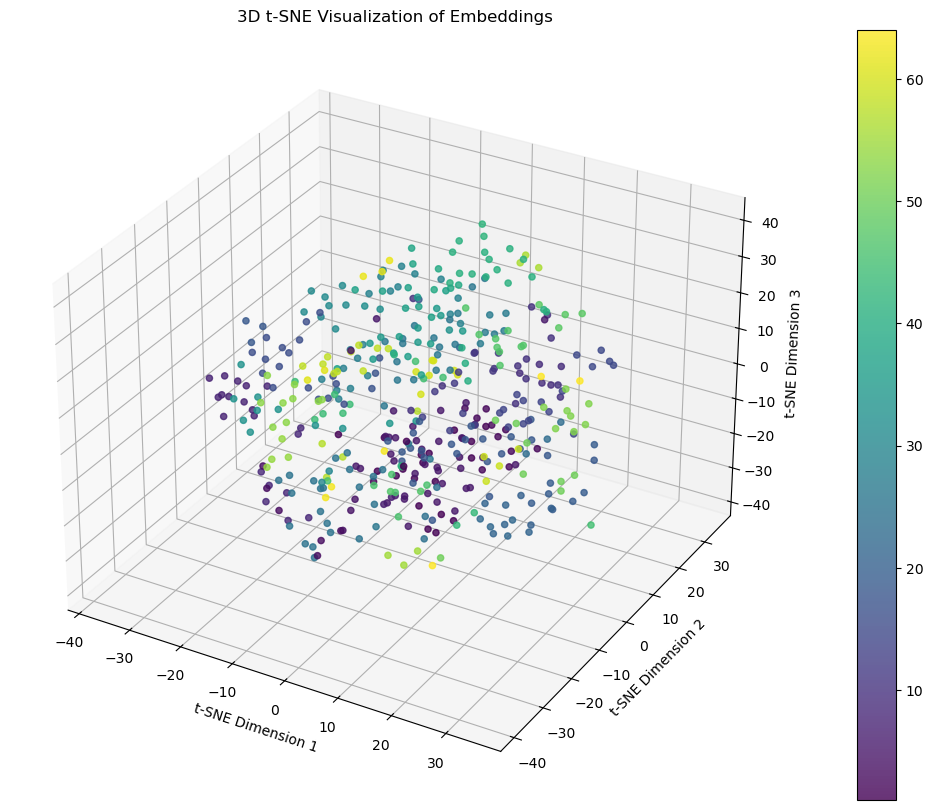

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import numpy as np
import pandas as pd

# Assuming 'sample_df' contains a column 'openai_embedding_entire' with appropriate data
embeddings = np.vstack(sample_df['openai_embedding_entire'].values)

# Apply t-SNE to the embeddings with 3 components for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)

# Plotting the t-SNE result with labels in 3D
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
scatter = ax.scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    tsne_results[:, 2],
    c=sample_df['new_cluster_index'],
    cmap='viridis',  # Viridis is a good perceptually-uniform colormap for distinguishing clusters
    alpha=0.8
)

# Adding labels and title
ax.set_title('3D t-SNE Visualization of Embeddings')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
fig.colorbar(scatter)

# Show the plot
plt.show()


In [53]:
# Prepare DataFrame for Plotly
plot_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
plot_df['cluster'] = clusters  # Add cluster assignments to the DataFrame

# Plot using Plotly with clusters
fig = px.scatter(plot_df, x='x', y='y', color='cluster', hover_data=['cluster'])
fig.update_traces(marker_size=10)
fig.update_layout(title='2D Visualization of Embeddings with 30 Clusters', hovermode='closest')
fig.show()


NameError: name 'embeddings_2d' is not defined

In [270]:
sorted_generated_labels.head()

new_cluster_index           generated_cluster_label
0                  0         AI Research & Development
1                  1       AI Development & Deployment
2                  2        AI Development & Assurance
3                  3                 AI Tool Ecosystem
4                  4  AI Automation & No-Code Platform

In [286]:
for i in range(0,1):
    vals = sample_df[(sample_df["new_cluster_index"]==0) | (sample_df["generated_cluster_label"]=="x")]
    if len(vals) < 0: continue
    label = vals.generated_cluster_label.iloc[0]
    print(f"Processing {i} and {label}:\n************************\n")
    for index, row in vals.iterrows():
        print(f"Organization Name: {row['organization name']}")
        print(f"Generated Description: {row['generated_description']}")
        print(f"Generated Description: {row['parsed_description']}\n")
    print(f"************************\n\n")

Processing 0 and AI Research & Development:
************************

Organization Name: Synthine
Generated Description: Synthine is an AI research lab dedicated to developing and applying deep generative AI solutions to create robust interfaces. Their focus lies in practical generative technologies, aiming to revolutionize the way we interact with AI systems.
Generated Description: 
Tasks/Jobs: AI interface design, Generative model development, User interaction design, AI system optimization 
Industry: AI Research
People Using Tool: AI researchers, Developers
 


Organization Name: ANIMA AI
Generated Description: ANIMA AI is a platform that leverages advanced AI research and technology to transform them into popular consumer products. It provides businesses with the opportunity to innovate and create AI-driven goods that cater to the evolving needs of consumers.
Generated Description: 
Tasks/Jobs: Product development, AI research, Consumer product creation, Innovation
Industry: Consum

In [272]:
grouped_counts = sample_df.groupby("new_cluster_index").aggregate({
    'generated_cluster_label': 'first', 
    'organization name': 'count'        
}).rename({"organization name":"count"},axis=1)
grouped_counts

generated_cluster_label  count
new_cluster_index                                         
0                         AI Research & Development      3
1                       AI Development & Deployment      7
2                        AI Development & Assurance      5
3                                 AI Tool Ecosystem      5
4                  AI Automation & No-Code Platform      3
...                                             ...    ...
80                   Insurance Management & Support      2
81                   Personal & Professional Growth      3
82                      Sales Outreach & Automation      2
83                       High-Performance Computing      3
84                        Data Quality & Management      2

[82 rows x 2 columns]

In [273]:
for index, row in grouped_counts.iterrows():
    print(f"{row['generated_cluster_label']}, Count: {row['count']}")
    

AI Research & Development, Count: 3
AI Development & Deployment, Count: 7
AI Development & Assurance, Count: 5
AI Tool Ecosystem, Count: 5
AI Automation & No-Code Platform, Count: 3
AI-Powered Fashion, Count: 5
AI-Powered Tools for Creative & Business, Count: 14
AI-Powered Customer Service, Count: 6
AI-Powered Customer & Business Support, Count: 6
AI-Powered Solutions, Count: 14
AI-Powered Business Solutions, Count: 6
AI-Powered Image Solutions, Count: 7
AI-Powered Design & Marketing, Count: 3
AI-Powered Social & Event Tools, Count: 3
AI & Business, Count: 9
AI Business Solutions, Count: 9
Tech & Business Solutions, Count: 8
Business Automation & Analytics, Count: 8
Customer Intelligence & Growth, Count: 4
Customer Engagement & Automation, Count: 5
Data Analysis & Insights, Count: 6
Financial Management & Analytics, Count: 6
Market Research & Business Strategy, Count: 4
Financial Risk & Compliance, Count: 4
Music Production & Creation Tools, Count: 7
Content Creation & Audio Tools, Cou

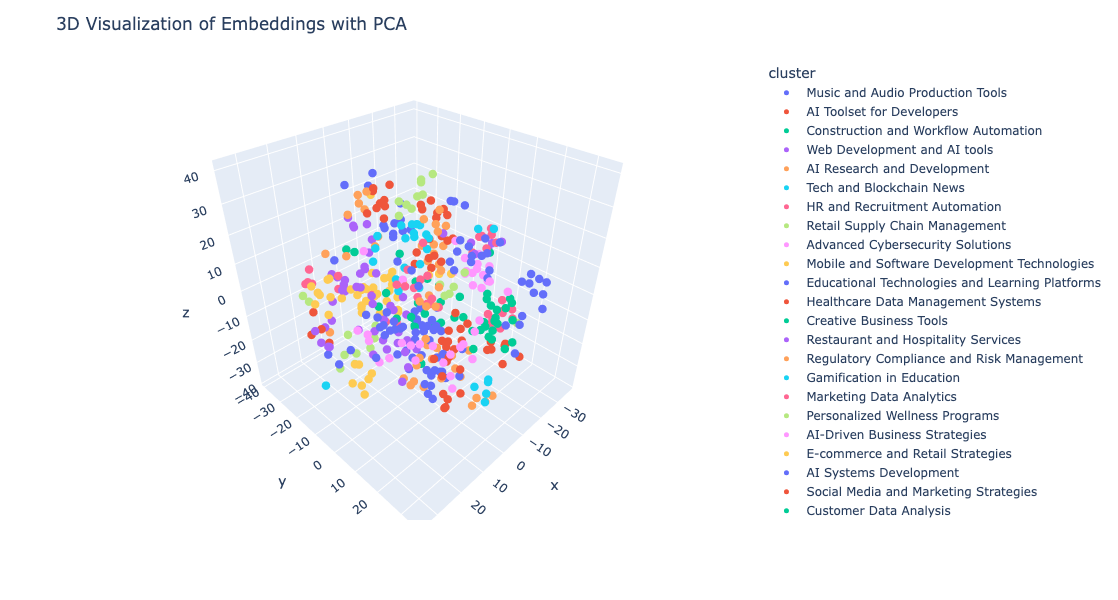

In [54]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

clusters = sample_df["generated_cluster_label"]

# Use PCA to reduce dimensions to 3 for 3D visualization
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(np.array(sample_df['openai_embedding_entire'].tolist()))

# Prepare DataFrame for Plotly
plot_df = pd.DataFrame(tsne_results, columns=['x', 'y', 'z'])
plot_df['cluster'] = clusters  # Add cluster assignments to the DataFrame

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(plot_df, x='x', y='y', z='z', color='cluster', hover_data=['cluster'])
fig.update_traces(marker_size=5)
fig.update_layout(
    title='3D Visualization of Embeddings with PCA',
    hovermode='closest',
    width=1000,  # Set the width of the figure
    height=600  # Set the height of the figure
)
# Show the plot
fig.show()


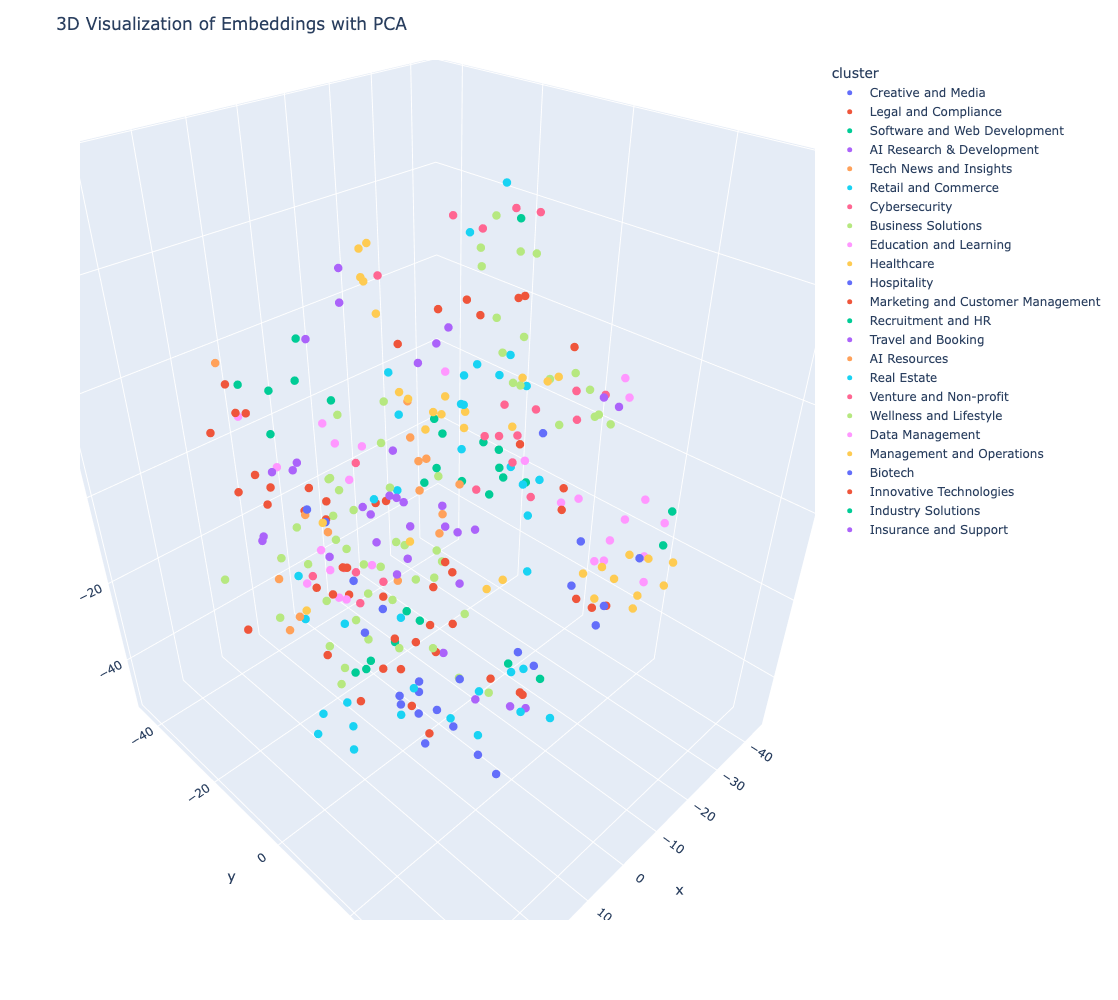

In [292]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

clusters = sample_df["merged_label"]

# Use PCA to reduce dimensions to 3 for 3D visualization
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(np.array(sample_df['openai_embedding_entire'].tolist()))

# Prepare DataFrame for Plotly
plot_df = pd.DataFrame(tsne_results, columns=['x', 'y', 'z'])
plot_df['cluster'] = clusters  # Add cluster assignments to the DataFrame

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(plot_df, x='x', y='y', z='z', color='cluster', hover_data=['cluster'])
fig.update_traces(marker_size=5)
fig.update_layout(
    title='3D Visualization of Embeddings with PCA',
    hovermode='closest',
    width=1000,  # Set the width of the figure
    height=1000  # Set the height of the figure
)
# Show the plot
fig.show()


In [145]:
tsne_results

array([[-20.14677  ,   2.0260096, -30.416681 ],
       [-18.313572 ,  -1.406669 , -31.094774 ],
       [ -7.3892174, -16.522545 ,   0.8111613],
       ...,
       [  1.9683405,  17.504587 , -24.546268 ],
       [  6.5245504,  16.097193 ,   2.4974155],
       [ 10.679577 ,  17.057632 ,   1.6603855]], dtype=float32)

In [288]:
services_mapping = {
    "AI Research & Development": [
        "AI Research & Development",
        "AI Development & Deployment",
        "AI Development & Assurance",
        "AI Tool Ecosystem",
        "AI Automation & No-Code Platform"
    ],
    "Creative and Media": [
        "Fashion",
        "Music Production & Creation Tools",
        "Tools for Creative & Business",
        "Content Creation & Audio Tools",
        "Design & Marketing",
        "Animation & VFX Production Tools"
    ],
    "Software and Web Development": [
        "Website & Software Optimization",
        "Mobile & Software Development",
        "Dev Tools & Automation",
        "DevOps & Infrastructure Management"
    ],
    "Tech News and Insights": [
        "Web3 & Tech News Automation",
        "Social & Digital Insights"
    ],
    "Retail and Commerce": [
        "Retail Operations & Supply Chain Management",
        "Retail & E-commerce",
        "E-commerce Operations & Management",
        "Industrial Procurement & Sourcing"
    ],
    "Cybersecurity": [
        "Cybersecurity Platform",
        "Cybersecurity & Data Privacy Automation"
    ],
    "Business Solutions": [
        "Tech & Business Solutions",
        "AI & Business",
        "AI Business Solutions",
        "Business Solutions",
        "Business Automation & Analytics",
        "Financial Management & Analytics",
        "Sales Automation for Industrial Equipment",
        "Accounting & Tax Automation",
        "Financial Risk & Compliance"
    ],
    "Marketing and Customer Management": [
        "Marketing Automation & Analytics",
        "Social Media Marketing Suite",
        "Customer Intelligence & Growth",
        "Customer Engagement & Automation",
        "Customer & Business Support",
        "AI Content & Marketing Tools"
    ],
    "Legal and Compliance": [
        "Construction Workflow Automation",
        "Legal Tech Automation",
        "Legal Client Management",
        "Compliance & Risk Management",
        "Document Automation for Business"
    ],
    "Education and Learning": [
        "EdTech & Learning",
        "Educational Gamification & Assessment",
        "Learning & Development Platforms",
        "Speech & Language Learning"
    ],
    "Healthcare": [
        "Healthcare Data & Management",
        "Healthcare Operations & Workflow",
        "Clinical AI Assistant",
        "Personalized Health & Wellness",
        "Mental Wellness & Therapy"
    ],
    "Hospitality": [
        "Restaurant & Hospitality Automation",
        "Hospitality & Travel Operations"
    ],
    "Travel and Booking": [
        "Travel Planning & Booking"
    ],
    "AI Resources": [
        "AI Resources & Education"
    ],
    "Venture and Non-profit": [
        "Venture Capital Operations",
        "Non-profit & Sustainability Solutions"
    ],
    "Wellness and Lifestyle": [
        "Sleep & Dream Wellness",
        "Personal & Professional Growth"
    ],
    "Recruitment and HR": [
        "Recruitment & HR Automation",
        "Job Search & Career Development Tools"
    ],
    "Real Estate": [
        "Real Estate & Investment Analytics",
        "Real Estate & Trust & Safety Automation",
        "Home Design & Visualization"
    ],
    "Data Management": [
        "Data Analysis & Insights",
        "Data Quality & Management",
        "Market Research & Business Strategy"
    ],
    "Management and Operations": [
        "Team & Project Management",
        "Proposal & Technical Writing Automation"
    ],
    "Innovative Technologies": [
        "Decentralized Technologies & Digital Identity",
        "High-Performance Computing"
    ],
    "Insurance and Support": [
        "Insurance Management & Support"
    ],
    "Biotech": [
        "Biotech Research & Development"
    ],
    "Industry Solutions": [
        "Industrial Automation Solutions"
    ],
    "Event and Social Tools": [
        "Social & Event Tools"
    ]
}

vals = []
for x in services_mapping:
    for y in services_mapping[x]:
        vals.append([x, y])
merged_labels = pd.DataFrame(vals, columns=["merged_label", "generated_cluster_label"])


In [289]:
for i in range(0,1):
    vals = sample_df[(sample_df["new_cluster_index"]==1000) | (sample_df["generated_cluster_label"]=="AI & Business")]
    if len(vals) == 0: continue
    label = vals.generated_cluster_label.iloc[0]
    print(f"Processing {i} and {label}:\n************************\n")
    for index, row in vals.iterrows():
        print(f"Organization Name: {row['organization name']}")
        print(f"Generated Description: {row['generated_description']}")
        print(f"Generated Description: {row['parsed_description']}\n")
    print(f"************************\n\n")

Processing 0 and AI & Business:
************************

Organization Name: FoundationFlow
Generated Description: FoundationFlow is a B2B platform that streamlines the deployment of generative AI business workflows, offering a cost-effective and secure solution for managing multi-modal LLMs. With advanced capabilities, it significantly reduces both the computational and memory requirements for training, leading to an average total cost of ownership reduction by 60%.
Generated Description: 
Tasks/Jobs: Generative AI workflow deployment, LLM management, Multi-modal LLM training, Cost optimization
Industry: Business automation
People Using Tool: Businesses, Developers
 


Organization Name: CloudGPT
Generated Description: CloudGPT is an innovative AI company providing cloud-based solutions powered by advanced generative pre-trained transformer (GPT) technology, specializing in natural language processing, machine learning, and data analytics. Their scalable platform is designed to serve 

In [290]:
merged_labels.merged_label.unique()

array(['AI Research & Development', 'Creative and Media',
       'Software and Web Development', 'Tech News and Insights',
       'Retail and Commerce', 'Cybersecurity', 'Business Solutions',
       'Marketing and Customer Management', 'Legal and Compliance',
       'Education and Learning', 'Healthcare', 'Hospitality',
       'Travel and Booking', 'AI Resources', 'Venture and Non-profit',
       'Wellness and Lifestyle', 'Recruitment and HR', 'Real Estate',
       'Data Management', 'Management and Operations',
       'Innovative Technologies', 'Insurance and Support', 'Biotech',
       'Industry Solutions', 'Event and Social Tools'], dtype=object)

In [291]:
if "merged_label" in sample_df.columns:
    sample_df = sample_df.drop(columns="merged_label")
sample_df = sample_df.merge(merged_labels, on="generated_cluster_label")
sample_df.head()

Unnamed: 0.1  Unnamed: 0                  organization name num employees  \
0             1       18944  Semilla Co. (Flou / Seed Academy)          1-10   
1            10       22382                       NaijaBuzz300          1-10   
2            28       19022                         SONOTELLER          1-10   
3            82       22374                             AISong          1-10   
4           126       19675                            SoundAI          1-10   

  founded date                                        description  \
0   2023-02-01  Semilla Co. ("Seed") is building the future of...   
1   2024-03-03  NaijaBuzz300's AI content tools helps artists ...   
2   2023-02-01  SONOTELLER is an AI engine capable of 'listeni...   
3   2024-03-01  AISong.Fun is a platform that uses the AI to p...   
4   2023-04-17                                                  —   

                                          industries  \
0  Consumer Software, Content Creators, EdTech, L...   
1                                          Marketing   
2  Artificial Intelligence (AI), Music, SaaS, Sof...   
3                Artificial Intelligence (AI), Music   
4  Artificial Intelligence (AI), Information Tech...   

                     headquarters location  \
0  Fort Lauderdale, Florida, United States   
1                  Kaduna, Kaduna, Nigeria   
2                    Madrid, Madrid, Spain   
3                                        —   
4       Dubai, Dubai, United Arab Emirates   

                                       description.1  cb rank  ...  \
0  Building the future of the music and entertain...   43,978  ...   
1  Helping artists grow & scale up their music ca...        —  ...   
2                  SaaS AI music and lyrics analysis  240,839  ...   
3             Free AI Song, Music & Lyrics Generator        —  ...   
4  is an artificial intelligence service that is ...  330,604  ...   

                             Company  \
0  Semilla Co. (Flou / Seed Academy)   
1                       NaijaBuzz300   
2                         SONOTELLER   
3                             AISong   
4                            SoundAI   

                                  parsed_description  \
0  \nTasks/Jobs: Music Business Management, Marke...   
1  \nTasks/Jobs: Music production, Songwriting, M...   
2  \nTasks/Jobs: Music analysis, Playlist creatio...   
3  \nTasks/Jobs: Song composition, Music producti...   
4  \nTasks/Jobs: Music generation, Sound design, ...   

                                          Tasks/Jobs           Industry  \
0  Music Business Management, Marketing, Business...     Music Industry   
1  Music production, Songwriting, Marketing, Prom...              Music   
2  Music analysis, Playlist creation, Music disco...   Music technology   
3  Song composition, Music production, Lyrics gen...     Music creation   
4  Music generation, Sound design, Audio mixing, ...  Music production    

                         People Using Tool  \
0           Music Creators, Entrepreneurs    
1            Musicians, Labels, Promoters    
2  Music enthusiasts, Music professionals    
3             Artists, Creators, Musicians   
4                    Musicians, Producers    

                             openai_embedding_entire cluster_label  \
0  [-0.004338318016380072, -0.021966977044939995,...            33   
1  [-0.006098032463341951, -0.021988358348608017,...            33   
2  [-0.012888072989881039, -0.0282617025077343, -...            33   
3  [0.005447404459118843, -0.03911559656262398, -...            33   
4  [-0.0040488275699317455, -0.010498875752091408...            33   

             generated_cluster_label new_cluster_index        merged_label  
0  Music Production & Creation Tools                25  Creative and Media  
1  Music Production & Creation Tools                25  Creative and Media  
2  Music Production & Creation Tools                25  Creative and Media  
3  Music Production & Creation Tools 

In [293]:
len(sample_df)

325